In [ ]:
from google.colab import files
files.upload()  # → 여기서 로컬의 kaggle.json 업로드

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yejunjung2","key":"2af381249fda9ea846932fe57978e435"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!mkdir -p /content/drive/MyDrive/diffusion/cat_dataset

In [ ]:
!mkdir -p /content/drive/MyDrive/.kaggle
!cp kaggle.json /content/drive/MyDrive/.kaggle/
!chmod 600 /content/drive/MyDrive/.kaggle/kaggle.json

# 고양이 데이터셋 다운로드
!kaggle datasets download -d crawford/cat-dataset

# 압축 해제
!unzip -q cat-dataset.zip -d /content/drive/MyDrive/diffusion/cat_dataset

Dataset URL: https://www.kaggle.com/datasets/crawford/cat-dataset
License(s): CC0-1.0
 99% 4.01G/4.04G [01:09<00:00, 254MB/s]
100% 4.04G/4.04G [01:09<00:00, 62.7MB/s]


In [ ]:
import os
import shutil
from glob import glob

src = "/content/drive/MyDrive/diffusion/cat_dataset"
dst = "/content/drive/MyDrive/diffusion/cat_dataset_flat"

os.makedirs(dst, exist_ok=True)

# 모든 하위 폴더에서 이미지 복사
for f in glob(os.path.join(src, "**", "*.jpg"), recursive=True):
    shutil.copy(f, dst)

In [ ]:
import shutil
import os

target_dir = "/content/drive/MyDrive/diffusion/cat_dataset"

# 폴더 안의 모든 파일/하위폴더 삭제
for item in os.listdir(target_dir):
    item_path = os.path.join(target_dir, item)
    if os.path.isdir(item_path):
        shutil.rmtree(item_path)
    else:
        os.remove(item_path)

KeyboardInterrupt: 

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cpu


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import glob
import os

class CatImageDataset(Dataset):
    def __init__(self, root_dir, image_size=64):
        self.files = sorted(glob.glob(os.path.join(root_dir, "**", "*.jpg"), recursive=True))
        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])


    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        return self.transform(img)

# 경로는 네가 정리한 실제 Drive 경로로 맞춰줘
dataset_path = "/content/drive/MyDrive/diffusion/cat_dataset_flat"
image_size = 64
batch_size = 32

cat_dataset = CatImageDataset(dataset_path, image_size=image_size)
cat_dataloader = DataLoader(cat_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

# 확인용 한 배치
sample_batch = next(iter(cat_dataloader))
print(sample_batch.shape)  # [B, 3, 64, 64]

torch.Size([32, 3, 64, 64])


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52395 (\N{HANGUL SYLLABLE CEOS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48264 (\N{HANGUL SYLLABLE BEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51704 (\N{HANGUL SYLLABLE JJAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/us

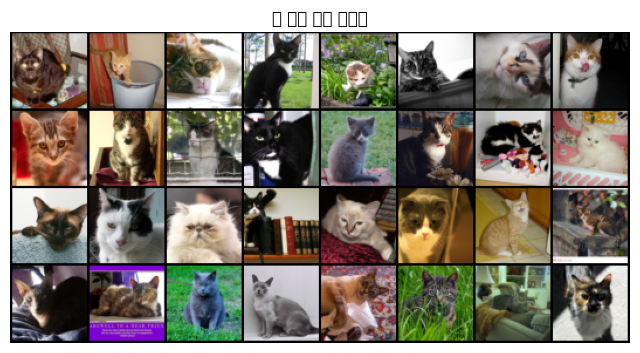

In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def show_image_batch(batch_tensor, nrow=8):
    grid = make_grid(batch_tensor[:nrow**2], nrow=nrow, normalize=True)
    plt.figure(figsize=(nrow, nrow))
    plt.axis('off')
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title("첫 번째 배치 이미지")
    plt.show()

# 실행
show_image_batch(sample_batch)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# 노이즈 스케줄 생성 함수: β₁, ..., β_T (선형 스케줄)
def make_beta_schedule(T, beta_start=1e-4, beta_end=0.02):
    return torch.linspace(beta_start, beta_end, T)

# Diffusion 클래스 정의
class Diffusion:
    def __init__(self, T=1000, beta_start=1e-4, beta_end=0.02, device="cuda"):
        self.T = T  # 전체 timestep 수 (노이즈 섞는 단계 수)
        self.device = device

        # 1. 베타 값 정의 (T개의 노이즈 강도 값)
        self.betas = make_beta_schedule(T, beta_start, beta_end).to(device)

        # 2. 알파 값: 정보 보존 비율 (1 - beta)
        self.alphas = 1. - self.betas

        # 3. 알파바: 누적된 정보 보존율 (알파들의 누적곱)
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

        # 4. 이전 알파바 값 (샘플링에 필요)
        self.alpha_bars_prev = torch.cat([
            torch.tensor([1.0], device=device),  # 첫 원소는 1.0
            self.alpha_bars[:-1]
        ])

        # 5. 수식에 자주 쓰이는 값들 미리 계산
        self.sqrt_alpha_bars = torch.sqrt(self.alpha_bars)
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1 - self.alpha_bars)
        self.posterior_variance = self.betas * (1. - self.alpha_bars_prev) / (1. - self.alpha_bars)

    # x₀ (원본 이미지)에 노이즈를 섞어서 xₜ 만들기
    def q_sample(self, x0, t, noise=None):
        """
        x₀ → xₜ: forward diffusion 과정
        xₜ = sqrt(ᾱₜ) * x₀ + sqrt(1 - ᾱₜ) * noise
        """
        if noise is None:
            # noise가 주어지지 않으면, 랜덤 노이즈 생성
            noise = torch.randn_like(x0)

        # t는 (B,) 형태인데, 브로드캐스팅을 위해 (B, 1, 1, 1)로 reshape
        t = t.view(-1, 1, 1, 1)

        # 각 이미지의 timestep에 맞는 ᾱₜ 값 가져오기
        sqrt_alpha_bar = self.sqrt_alpha_bars[t].to(self.device)
        sqrt_one_minus_alpha_bar = self.sqrt_one_minus_alpha_bars[t].to(self.device)

        # 노이즈 섞은 xₜ 반환
        return sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise

    # 학습 시 사용할 t 값을 랜덤하게 샘플링
    def sample_timesteps(self, batch_size):
        """
        1부터 T까지 중 무작위로 timestep 선택 (배치마다 다르게)
        """
        return torch.randint(low=1, high=self.T, size=(batch_size,))


In [ ]:
# PyTorch 기본
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 데이터 처리 관련
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

# 시각화
import matplotlib.pyplot as plt

# 기타
import numpy as np
import math

# 진행상황 표시 (학습 시)
from tqdm import tqdm


In [ ]:
import torch
import torch.nn as nn
import math

# Sinusoidal Time Embedding
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None].float() * emb[None, :]
        return torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)

# Time-Aware Convolutional Block
class TimeAwareConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, num_groups=8):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.norm1 = nn.GroupNorm(num_groups, out_ch)
        self.act1 = nn.SiLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.norm2 = nn.GroupNorm(num_groups, out_ch)
        self.act2 = nn.SiLU()

    def forward(self, x, t_emb):
        # 먼저 conv1 → 채널 수 맞춘 뒤에 time embedding 더하기
        x = self.conv1(x)
        temb = self.time_mlp(t_emb).unsqueeze(-1).unsqueeze(-1)  # (B, C, 1, 1)
        x = x + temb
        x = self.norm1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.act2(x)
        return x

# Full U-Net with Time Embedding
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, time_emb_dim=256):
        super().__init__()

        self.time_mlp = nn.Sequential(
            SinusoidalTimeEmbedding(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU()
        )

        self.down = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='nearest')

        self.conv1 = TimeAwareConvBlock(in_channels, 64, time_emb_dim)
        self.conv2 = TimeAwareConvBlock(64, 128, time_emb_dim)
        self.conv3 = TimeAwareConvBlock(128, 256, time_emb_dim)
        self.bot   = TimeAwareConvBlock(256, 512, time_emb_dim)
        self.up3   = TimeAwareConvBlock(512 + 256, 256, time_emb_dim)
        self.up2   = TimeAwareConvBlock(256 + 128, 128, time_emb_dim)
        self.up1   = TimeAwareConvBlock(128 + 64, 64, time_emb_dim)

        self.output = nn.Conv2d(64, out_channels, 1)

    def forward(self, x, t):
        t_emb = self.time_mlp(t)

        x1 = self.conv1(x, t_emb)
        x2 = self.conv2(self.down(x1), t_emb)
        x3 = self.conv3(self.down(x2), t_emb)
        x4 = self.bot(self.down(x3), t_emb)

        u3 = self.up3(torch.cat([self.up(x4), x3], dim=1), t_emb)
        u2 = self.up2(torch.cat([self.up(u3), x2], dim=1), t_emb)
        u1 = self.up1(torch.cat([self.up(u2), x1], dim=1), t_emb)

        return self.output(u1)

In [ ]:
ckpt_path = "/content/drive/MyDrive/diffusion/checkpoints"
os.makedirs(ckpt_path, exist_ok=True)  # 경로 없으면 자동 생성

In [ ]:
'''
def train(model, dataloader, optimizer, diffusion, epochs, device="cuda"):
    model.train()  # 모델을 학습 모드로 전환

    for epoch in range(epochs):
        print(f"\n🌱 Epoch {epoch+1}/{epochs}")
        pbar = tqdm(dataloader)

        for batch in pbar:
            # x0: 원본 이미지
            x0 = batch.to(device)

            # 1. 무작위 timestep t 선택
            t = diffusion.sample_timesteps(x0.shape[0]).to(device)

            # 2. 랜덤 노이즈 생성 (정답)
            noise = torch.randn_like(x0)

            # 3. Forward 과정: x₀ → xₜ
            xt = diffusion.q_sample(x0, t, noise)

            # 4. 모델에 xₜ와 t를 넣고 노이즈 예측
            noise_pred = model(xt, t)

            # 5. 손실 계산 (MSE: 예측한 노이즈 vs 실제 노이즈)
            loss = F.mse_loss(noise_pred, noise)

            # 6. 역전파 및 최적화
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 7. 진행률 표시
            pbar.set_description(f"Loss: {loss.item():.4f}")

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item()
        }, os.path.join(ckpt_path, f"checkpoint_epoch_{epoch+31}.pt"))
'''

In [ ]:
'''device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
'''
# 모델 초기화
model = UNet().to(device)
'''

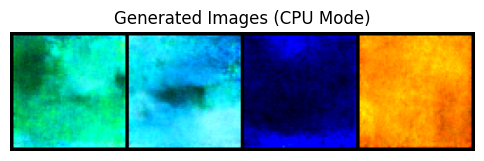

In [ ]:
# diffusion 인스턴스 생성 (객체)
diffusion = Diffusion(T=1000, device="cpu")

# 샘플 생성
samples = sample_images(model, diffusion, image_size=64, batch_size=4, device="cpu")
show_samples(samples)

In [ ]:
'''
# 모델 초기화
model = UNet().to(device)

# optimizer 정의
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Diffusion 객체
diffusion = Diffusion(T=1000, device=device)

checkpoint = torch.load("/content/drive/MyDrive/diffusion/checkpoints/checkpoint_epoch_30.pt", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# 학습 시작
# 덮어쓰는 방식이 되어버림
train(model, cat_dataloader, optimizer, diffusion, epochs=30, device=device)
'''


🌱 Epoch 1/30


Loss: 0.0333:  22%|██▏       | 39/175 [07:55<27:37, 12.19s/it]


KeyboardInterrupt: 

In [ ]:
'''checkpoint = torch.load("/content/drive/MyDrive/diffusion/checkpoints/checkpoint_epoch_29.pt", map_location=torch.device('cpu'))

In [ ]:
import os
from tqdm import tqdm
import torch.nn.functional as F

def train(model, dataloader, optimizer, diffusion, epochs, start_epoch=0, device="cuda", ckpt_path="./"):
    model.train()

    for epoch in range(start_epoch, start_epoch + epochs):
        print(f"\n🌱 Epoch {epoch}/{start_epoch + epochs - 1}")
        pbar = tqdm(dataloader)

        for batch in pbar:
            x0 = batch.to(device)

            # 1. 무작위 timestep t 선택
            t = diffusion.sample_timesteps(x0.shape[0]).to(device)

            # 2. 랜덤 노이즈 생성
            noise = torch.randn_like(x0)

            # 3. Forward 과정
            xt = diffusion.q_sample(x0, t, noise)

            # 4. 모델 예측
            noise_pred = model(xt, t)

            # 5. 손실 계산
            loss = F.mse_loss(noise_pred, noise)

            # 6. 역전파 및 최적화
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 7. 진행률 출력
            pbar.set_description(f"Loss: {loss.item():.4f}")

        # 8. checkpoint 저장
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item()
        }, os.path.join("/content/drive/MyDrive/diffusion/checkpoints/", f"checkpoint_epoch_{epoch}.pt"))

In [ ]:
# checkpoint 불러오기
checkpoint = torch.load("/content/drive/MyDrive/diffusion/checkpoints/checkpoint_epoch_30.pt", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1  # = 31

# 이어서 20 epoch 학습
train(model, cat_dataloader, optimizer, diffusion, epochs=20, start_epoch=start_epoch, device=device, ckpt_path=".../checkpoints")


🌱 Epoch 30/49


Loss: 0.0346: 100%|██████████| 175/175 [32:56<00:00, 11.29s/it]



🌱 Epoch 31/49


Loss: 0.0356: 100%|██████████| 175/175 [33:20<00:00, 11.43s/it]



🌱 Epoch 32/49


Loss: 0.0175: 100%|██████████| 175/175 [33:19<00:00, 11.43s/it]



🌱 Epoch 33/49


Loss: 0.0417: 100%|██████████| 175/175 [33:35<00:00, 11.52s/it]



🌱 Epoch 34/49


Loss: 0.0719: 100%|██████████| 175/175 [32:52<00:00, 11.27s/it]



🌱 Epoch 35/49


Loss: 0.0130: 100%|██████████| 175/175 [32:50<00:00, 11.26s/it]



🌱 Epoch 36/49


Loss: 0.0353: 100%|██████████| 175/175 [33:34<00:00, 11.51s/it]



🌱 Epoch 37/49


Loss: 0.0316: 100%|██████████| 175/175 [33:05<00:00, 11.34s/it]



🌱 Epoch 38/49


Loss: 0.0285: 100%|██████████| 175/175 [32:54<00:00, 11.28s/it]



🌱 Epoch 39/49


Loss: 0.0279: 100%|██████████| 175/175 [33:02<00:00, 11.33s/it]



🌱 Epoch 40/49


Loss: 0.0180: 100%|██████████| 175/175 [32:36<00:00, 11.18s/it]



🌱 Epoch 41/49


Loss: 0.0186: 100%|██████████| 175/175 [33:33<00:00, 11.51s/it]



🌱 Epoch 42/49


Loss: 0.0443: 100%|██████████| 175/175 [33:14<00:00, 11.39s/it]



🌱 Epoch 43/49


Loss: 0.0394: 100%|██████████| 175/175 [33:53<00:00, 11.62s/it]



🌱 Epoch 44/49


Loss: 0.0309: 100%|██████████| 175/175 [32:42<00:00, 11.22s/it]



🌱 Epoch 45/49


Loss: 0.0473: 100%|██████████| 175/175 [32:46<00:00, 11.24s/it]



🌱 Epoch 46/49


Loss: 0.0377: 100%|██████████| 175/175 [32:24<00:00, 11.11s/it]



🌱 Epoch 47/49


Loss: 0.0422: 100%|██████████| 175/175 [32:48<00:00, 11.25s/it]



🌱 Epoch 48/49


Loss: 0.0152: 100%|██████████| 175/175 [32:34<00:00, 11.17s/it]



🌱 Epoch 49/49


Loss: 0.0321: 100%|██████████| 175/175 [33:24<00:00, 11.45s/it]


In [ ]:
import matplotlib.pyplot as plt

@torch.no_grad()
def sample_images(model, diffusion, image_size=64, batch_size=4, channels=3, device=device):
    model.eval()
    x = torch.randn((batch_size, channels, image_size, image_size)).to(device)

    for t in reversed(range(1, diffusion.T)):
        t_batch = torch.full((batch_size,), t, device=device, dtype=torch.long)
        eps_theta = model(x, t_batch)

        alpha_t = diffusion.alphas[t].to(device)
        alpha_bar_t = diffusion.alpha_bars[t].to(device)
        alpha_bar_t_prev = diffusion.alpha_bars_prev[t].to(device)

        beta_t = diffusion.betas[t].to(device)

        # mean 계산
        mean = (
            1 / torch.sqrt(alpha_t)
            * (x - (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t) * eps_theta)
        )

        # variance 계산
        if t > 1:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)  # 마지막 step은 noise 제거

        var = torch.sqrt(beta_t)
        x = mean + var * noise

    return x

def show_samples(images):
    images = images.clamp(0., 1.)  # 값 범위 제한
    images = images.permute(0, 2, 3, 1).cpu().numpy()

    fig, axes = plt.subplots(1, len(images), figsize=(15, 4))
    for img, ax in zip(images, axes):
        ax.imshow(img)
        ax.axis("off")
    plt.suptitle("Generated Images")
    plt.show()

def test_model(epoch):
    # 모델, 옵티마이저, diffusion 정의 (학습과 동일한 구조로)
    model = UNet().to(device)  # 또는 "cuda"
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # diffusion 객체도 동일하게
    diffusion = Diffusion(T=1000, device=device)

    # checkpoint 로드
    checkpoint = torch.load(f"/content/drive/MyDrive/diffusion/checkpoints/checkpoint_epoch_{epoch}.pt", map_location="cpu")

    # 가중치 로딩
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # 추론 모드 전환

    samples = sample_images(model, diffusion, image_size=64, batch_size=4, device=device)

    show_samples(samples)

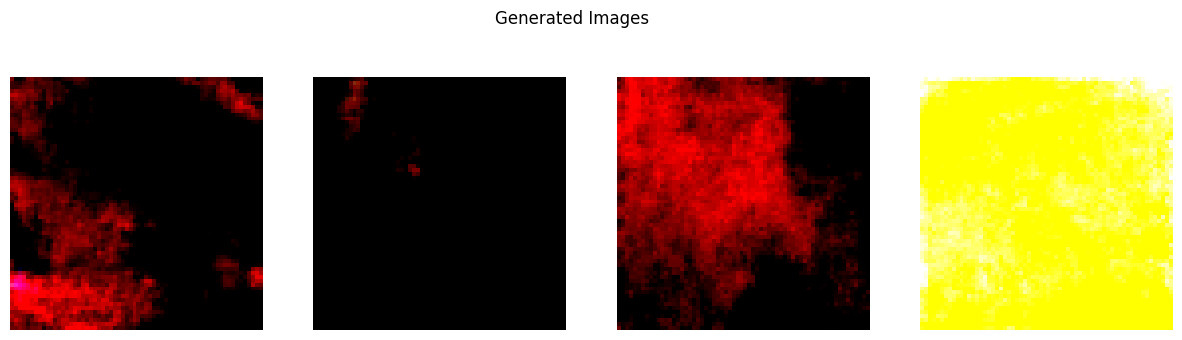

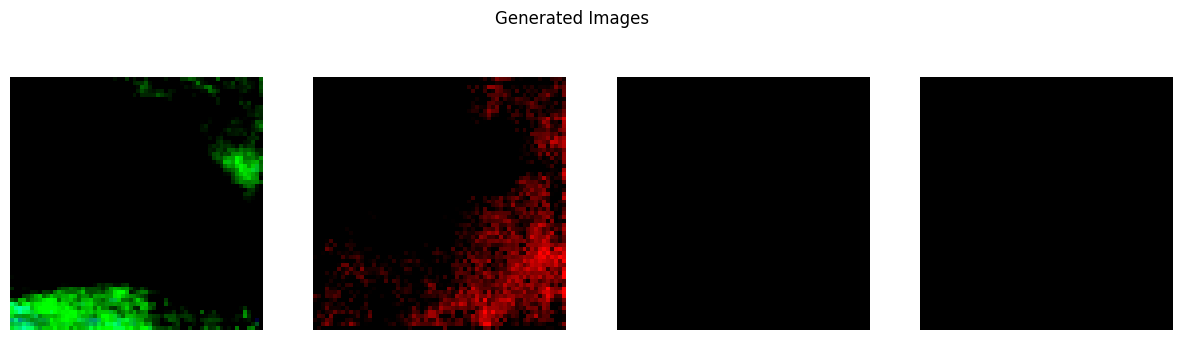

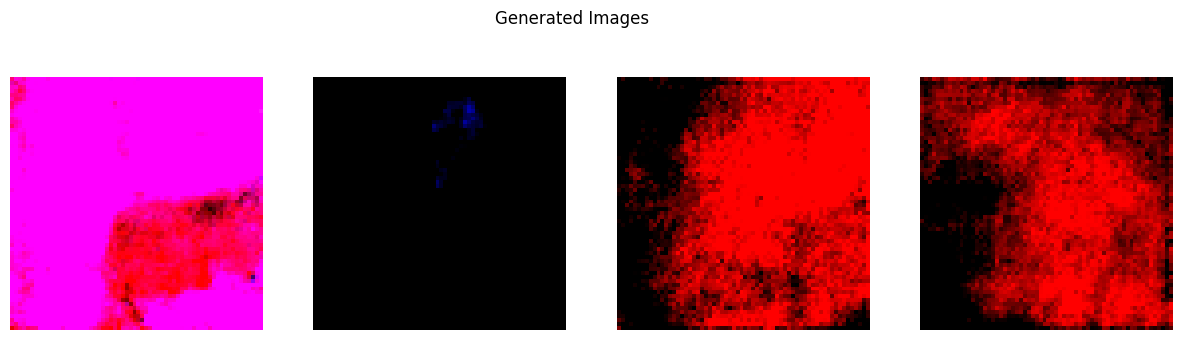

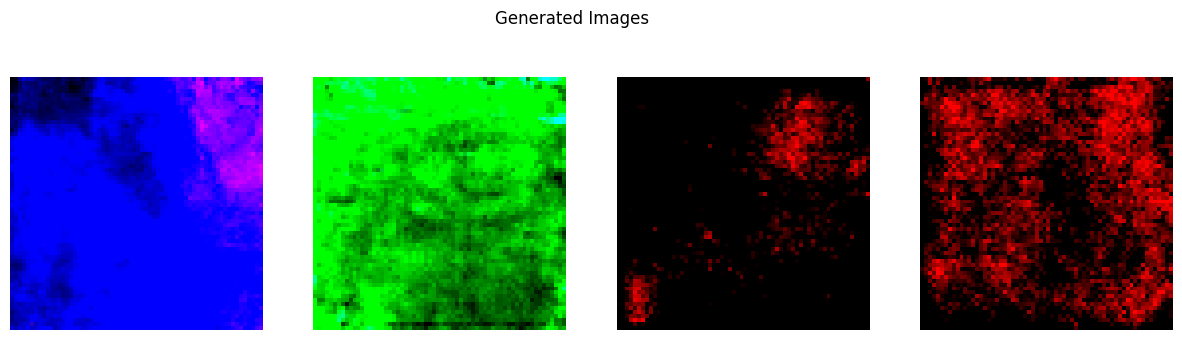

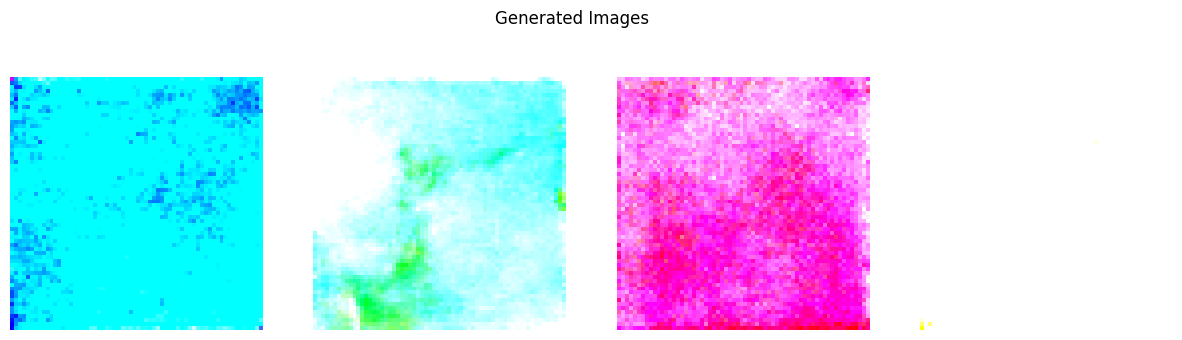

In [ ]:
for i in range(29, 50, 5):
    test_model(i)